## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/Gerst/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/Gerst/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/images/0001TP_006750.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/Gerst/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/Gerst/.fastai/data/camvid/labels/0001TP_006750_P.png')]

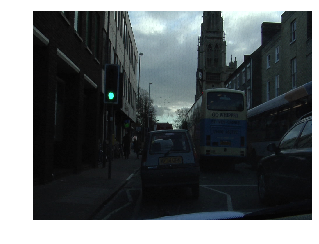

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

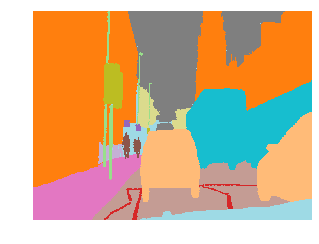

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [19]:
size = src_size//2
bs=2

In [20]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [21]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

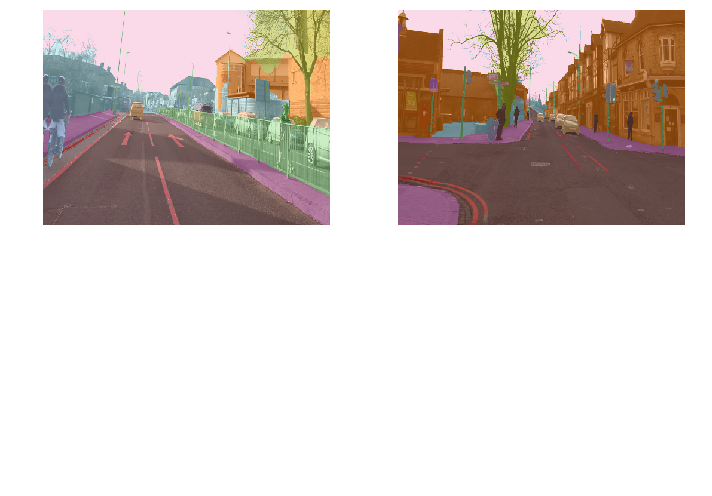

In [22]:
data.show_batch(2, figsize=(10,7))

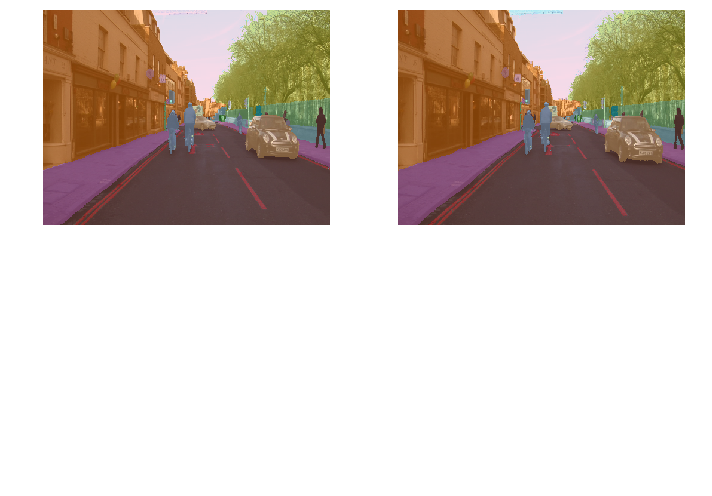

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [25]:
metrics=acc_camvid
# metrics=accuracy

In [26]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


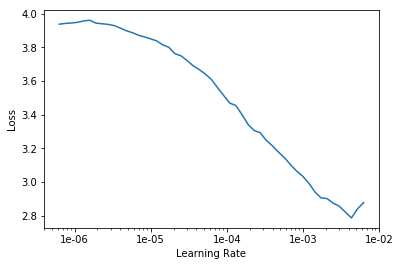

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
lr=3e-3

In [30]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,0.902273,0.807824,0.761208
2,0.861287,0.758253,0.833513
3,0.643319,0.485463,0.874999


In [31]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=2

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin